# Diagnostics

In [1]:
import numpy as np
import scipy.stats as ss

import elfi

import logging
logging.basicConfig(level=logging.INFO)

In [2]:
from elfi.methods import diagnostics

## Summary Statistics Selection

One of the most difficult aspects in likelihood-free inference is finding a good way to compare simulated and observed data. This is typically accomplished via a set of summary statistics, but they tend to be very problem-specific. ELFI includes tools to aid this selection in the form of the Two Stage Procedure proposed by [Nunes & Balding (2010)](https://www.degruyter.com/view/j/sagmb.2010.9.1/sagmb.2010.9.1.1576/sagmb.2010.9.1.1576.xml), which determines a well-performing summary-statistics combination. The procedure can be summarised as follows:

- First, all possible combinations of the candidate summary statistics are generated (can also be user-given)
- Stage 1:
    - Each summary statistics combination is evaluated using the Minimum Entropy algorithm
    - The minimum entropy combination is selected, and the 'closest' datasets are identified
- Stage 2:
    - For each summary statistics combination, the mean root sum of squared errors (MRSSE) is calculated over all 'closest' datasets
    - The minimum MRSSE combination is chosen as the one with the optimal performance.

### Example: Summary-statistics selection for the MA2 model

We will again use the MA2 example introduced in the [tutorial](tutorial.ipynb), where we used the first two autocovariances as the summary statistics: one with `lag=1`, another with `lag=2`.

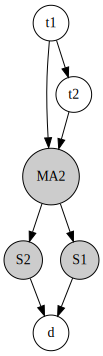

In [3]:
from elfi.examples import ma2
m = ma2.get_model()
elfi.draw(m)

Let's see if it would be beneficial try other summary statistics as well, for example the mean and the variance. To use the Two-Stage Selection process, we have to define the ElfiModel up until **the node for which the summary statistics will be applied**, which is typically the simulator node (here, named *MA2*). Because the MA2 example defines a complete ElfiModel, we have to remove the summary statistics (and anything after them, in this case the distance) from it:

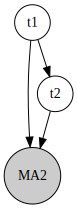

In [4]:
m.remove_node('S1')
m.remove_node('S2')
m.remove_node('d')
elfi.draw(m)

Next we need to define a list of candidate summary statistics:

In [5]:
autocov1 = ma2.autocov

# doesn't work with functools.partial at the moment
def autocov2(x):
    return ma2.autocov(x, lag=2)

def mean(y):
    return np.mean(y, axis=1)

def var(y):
    return np.var(y, axis=1)

# Initialising the list of assessed summary statistics.
list_ss = [autocov1, autocov2, mean, var]

ELFI will generate all possible combinations of these candidates, and build an ElfiModel for each combination by generating child nodes to the user-given node (here, the simulator node MA2). A distance node between the summary statistics can be given as a function or string as with `elfi.Distance` or `elfi.Discrepancy` (here, 'euclidean'): 

In [6]:
selection = diagnostics.TwoStageSelection(m['MA2'], 'euclidean', list_ss=list_ss)

Sometimes the generated list of combinations may be very long. If you are able to make an educated guess about which combinations are the most promising, you can save computational time by providing these combinations to ELFI. This can be done by replacing the `list_ss` keyword argument with for example: 

`prepared_ss=[[autocov1], [autocov1, autocov2], [mean, var]]` 

and then ELFI will only consider these combinations.

After these preparations, we can execute the selection process as follows:

In [7]:
ss = selection.run(n_sim=100000, batch_size=10000)

INFO:elfi.methods.diagnostics:Combination ['autocov'] shows the entropy of -0.541874
INFO:elfi.methods.diagnostics:Combination ['autocov2'] shows the entropy of 0.458047
INFO:elfi.methods.diagnostics:Combination ['mean'] shows the entropy of 0.970787
INFO:elfi.methods.diagnostics:Combination ['var'] shows the entropy of 0.574364
INFO:elfi.methods.diagnostics:Combination ['autocov', 'autocov2'] shows the entropy of -1.210676
INFO:elfi.methods.diagnostics:Combination ['autocov', 'mean'] shows the entropy of -0.516352
INFO:elfi.methods.diagnostics:Combination ['autocov', 'var'] shows the entropy of -0.674324
INFO:elfi.methods.diagnostics:Combination ['autocov2', 'mean'] shows the entropy of 0.357350
INFO:elfi.methods.diagnostics:Combination ['autocov2', 'var'] shows the entropy of -0.124121
INFO:elfi.methods.diagnostics:Combination ['mean', 'var'] shows the entropy of 0.478768
INFO:elfi.methods.diagnostics:Combination ['autocov', 'autocov2', 'mean'] shows the entropy of -1.000878
INFO:elf

In [8]:
ss

(<function elfi.examples.ma2.autocov>, <function __main__.autocov2>)

So the Two-Stage Procedure supports our earlier decision to use the autocovariances with lags 1 and 2. :)

The method includes further options for tuning the selection process, please check the [documentation](http://elfi.readthedocs.io) for more details.